Notes to self
This is tempermental to module version
Use base conda env on MacBook Pro laptop

In [1]:
# --------------------------------------------------- #
# Specific version for current Scarlet2               #
# run this is having issue with commands not existing #
# make a standalone conda env for now, fix later      #
# --------------------------------------------------- #

In [2]:
# specify to reload any packages that are changed
# helps with not having to restart the kernel each time
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import jax.numpy as jnp
import equinox as eqx
from jax import random, jit
#import distrax
import matplotlib.pyplot as plt
from scarlet2 import *
import optax
from tqdm.auto import tqdm
import pandas as pd
import warnings
import jax
from functools import partial
from collections.abc import Hashable   
from matplotlib.patches import Rectangle
warnings.filterwarnings("ignore") 

In [4]:
# ----------------------------------- #
# grab images from the HSC catalogue  #
# read them into jax arrays and then  #
# make a multi-band image             #
# ----------------------------------- #
# use 14090 great examle
# 15290 ok

data_name = 'data_HSC_9697_patch_72.pkl' # storing just one patch locally so use it
df = pd.read_pickle(data_name) # 13827 is cool
data = df[df['parent_ID']==df['parent_ID'][14090]] # select one randome scene 15100 is cool
#data = df[df['parent_ID']==df['parent_ID'][15100]] # select one randome scene 15100 is cool

# make multi-band data
multi_images = np.array([np.array(data['scene_g'])[0] , np.array(data['scene_r'])[0]  , np.array(data['scene_i'])[0]  , 
                        np.array(data['scene_y'])[0]  , np.array(data['scene_z'])[0] ]) 
multi_filters = np.array([np.array(data['mask_g'])[0] , np.array(data['mask_r'])[0]  , np.array(data['mask_i'])[0]  , 
                        np.array(data['mask_y'])[0]  , np.array(data['mask_z'])[0] ]) 
multi_var = np.array([np.array(data['var_g'])[0] , np.array(data['var_r'])[0]  , np.array(data['var_i'])[0]  , 
                        np.array(data['var_y'])[0]  , np.array(data['var_z'])[0] ]) 
multi_psf = np.array([np.array(data['PSF_g'])[0] , np.array(data['PSF_r'])[0]  , np.array(data['PSF_i'])[0]  , 
                        np.array(data['PSF_y'])[0]  , np.array(data['PSF_z'])[0] ]) 

images = multi_images 
centers = jnp.asarray( [(src[0], src[1]) for src in data["loc"]] )
box_size = jnp.asarray( [(src) for src in data["box_sz"]] )
weights = 1/multi_var 
psf = multi_psf
obs = Observation(images, weights, psf=ArrayPSF(jnp.asarray(psf)))
frame_psf = GaussianPSF(jnp.array((0, 0.2)), 0.7)
model_frame = Frame(Box(images.shape), psf=frame_psf)
obs.match(model_frame);

print('----------------------------------------')
print(f"    Scene contains {len(data['loc'])} galaxy sources")
print('----------------------------------------')

----------------------------------------
    Scene contains 6 galaxy sources
----------------------------------------


In [5]:
morph_init_scarlet = np.array([i for i in data['scar_g'] ])

In [6]:
# define initial circular model for initial morphology estimate 
from skimage import draw

# empty list
morph_init = [None]*len(centers)
key = random.split(random.PRNGKey(0), 1)
sigma = .5 # noise factor

for i, bx in enumerate(box_size):
    arr = np.zeros((bx, bx))
    rr, cc = draw.disk((bx/2, bx/2), radius=bx/10, shape=arr.shape)
    arr[rr, cc] = 1
    noise = random.normal(key, (box_size[i], box_size[i]))
    raw =  (jnp.array(arr) + sigma * noise)
    normed = (raw-jnp.min(raw))/(jnp.max(raw)-jnp.min(raw))
    morph_init[i] = normed
    
# plt.imshow(morph_init[0])

In [7]:
# try to mess around getting prior to work
# TODO: determine best way to ensure prior is being used

keys = random.split(random.PRNGKey(0), 2)
with Scene(model_frame) as scene:
    for i in range(len( centers )):
        Source(
            centers[i],
            ArraySpectrum(random.normal(keys[0], (5,)), constraint=PositiveConstraint()),
            #ArrayMorphology(morph_init[i], prior=NNPrior())
            ArrayMorphology(morph_init_scarlet[i], prior=NNPrior())
        )

In [8]:
from jax import jvp, grad
import jax
import cmasher as cmr

# forward-over-reverse
# efficient way
def hvp(f, primals, tangents):
  return jvp(grad(f), primals, tangents)[1]
  

# equation 9 
# run this multiple times to the convergence
# https://arxiv.org/pdf/2006.00719.pdf
# look into this more later
#@jax.jit
def hvp_rad(f, primals, shape):
  '''Diagonal hessian approximation using the
  hessian vector product and the Rademacher approximation.'''
  #keys = random.split(random.PRNGKey(0), 2)
  draws = 500
  H = np.zeros(shape)
  for i in range(draws):
    keys = random.split(random.PRNGKey(i), 2)
    z =jax.random.rademacher(keys[0], shape , dtype=jnp.float32)
    HVP = eqx.filter_jvp(f, primals, (z,))[1]
    H += jnp.multiply(z,HVP)
  return H


fitting sources:   0%|          | 0/200 [00:00<?, ?it/s]

final step=199 loss=76224.4375


KeyboardInterrupt: 

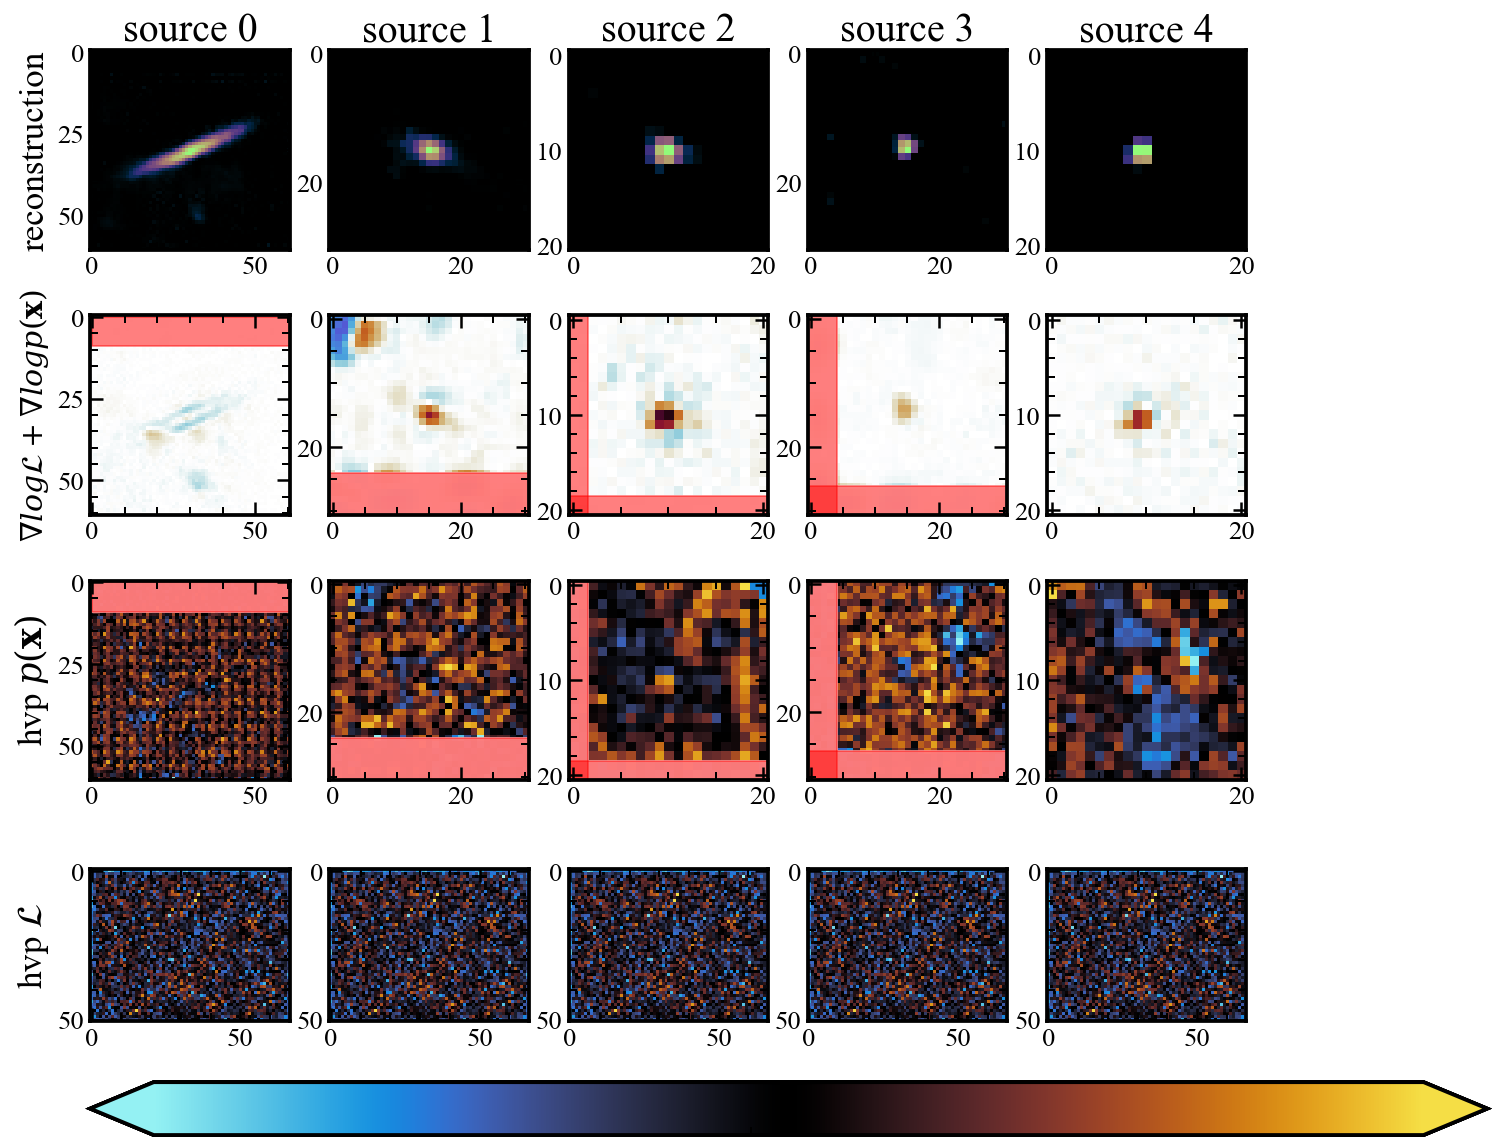

In [10]:
# TODO: fix "jax.tree_structure" is deprecated so we can use latest jax and equinox
# TODO: fix the non-hashable item in Observation class so we can use jit
src_num = len( centers )
weight = 1

# ------------------ #
# tracking functions #
# ------------------ #
@eqx.filter_value_and_grad
def lik_grad(model, obs, weight):
    sources = model()
    neg_log_like = -obs.log_likelihood(sources)
    return  neg_log_like

@eqx.filter_value_and_grad
def neural_grad(model, obs, weight):
    prior = 0.0
    sources = model()
    for i in range(src_num):
        prior += weight * model.sources[i].morphology.prior.log_prob( model.sources[i].morphology.value )
    return  -prior 

def track_grad(model, obs, weigth):
    loss1, grad_lik    = lik_grad(model, obs, weigth)
    loss1, grad_neural = neural_grad(model, obs, weigth)
    return grad_lik, grad_neural

# ------------------ #
# main train routine #
# ------------------ #
@eqx.filter_value_and_grad
def loss_fn_with_grad(model, obs, weight):
    prior = 0.0
    sources = model()
    neg_log_like = -obs.log_likelihood(sources)
    for i in range(src_num):
        prior += weight * model.sources[i].morphology.prior.log_prob( model.sources[i].morphology.value )
    return  neg_log_like - prior  

#@eqx.filter_jit
# TODO: Hash error when using jit in the Observation class -- think I need to convert tuple to list?
def make_step(model, obs, opt_state, weigth):
    loss, grads = loss_fn_with_grad(model, obs, weigth)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, grads, model, opt_state

scene_init = scene
obs_init = obs
for i in range(1):
    scene = scene_init
    obs = obs_init
    learning_rate= 3e-1 # alter this
    optim = optax.adam(learning_rate)
    opt_state = optim.init(eqx.filter(scene, eqx.is_array))
    best_loss = 1e20
    iters = 200
    loss_vec = []
    factor_vec = []
    #grad_factor = jnp.linspace(max_weight, 1, iters)
    grad_factor = 1 * jnp.logspace(2,1, iters)

    pbar = tqdm(range(iters), desc='fitting sources')
    for step in pbar:
        
        loss, grads, scene, opt_state = make_step(scene, obs, opt_state, weight)
        loss = loss.item()
        #weight = grad_factor[step]
        weight = 20
        loss_vec.append(loss)
        factor_vec.append(weight)
        pbar.set_description(f" fitting sources ==>  step: {step} loss: {loss}")
            
        # track gradient evolution
        if step == iters -2:
            grad_lik, grad_neural = track_grad(scene, obs, weight)
            #hessian_nn = jvp(neural_grad, scene, jnp.eye(scene.shape)[1]
            
    print(f"final step={step} loss={loss}")

    # test to see if issue is with image storage type
    # NOTE: nope works fine. grads correctly calculated, but not with the log_prior routine

    int_method = 'none'
    cmap = cmr.iceburn
    cbar = False

    fig = plt.figure(figsize=(15, 11), dpi = 120)
    num_src = len( scene.sources )
    for idx in range(num_src):
        nn_grad_fun = jax.grad(scene.sources[idx].morphology.prior.log_prob)
        sourcesL    = scene()
        lik_grad_fun = jax.grad(likelihood(scene, obs))
        grad_nn    = grad_neural.sources[idx].morphology.value
        grad_nll   = grad_lik.sources[idx].morphology.value
        grad_used  = grads.sources[idx].morphology.value
        morphology = scene.sources[idx].morphology.value
        
        # tracking likelihood
        def solo_like(sources):
            return -obs.log_likelihood(sources)

        ll_grad_fun = jax.grad(solo_like)
        hvp_ll    = hvp_rad(ll_grad_fun, (sourcesL,), sourcesL.shape)
        
        # make ones and identity matrix
        hvp_nn    = hvp_rad(nn_grad_fun, (grad_nn,), grad_nn.shape) 
        #hvp_ll    = hvp_rad(lik_grad_fun, (grad_nll,), grad_nll.shape)

        
        # source morphology
        plt.subplot(4, num_src, idx + 1)
        plt.imshow(morphology,cmap = cmr.lilac, vmin = 0,interpolation=int_method)
        # ax = plt.gca()
        # ax.invert_xaxis()
        plt.title(f"source {idx}", fontsize = 24)
        if idx==0:
            plt.ylabel("reconstruction", fontsize = 21)

            
        # nn grads
        plt.subplot(4, num_src, idx + 1 * num_src + 1)
        ax = plt.gca()
        ax.invert_xaxis()
        tmax = np.max(np.abs(grad_nn))
        plt.imshow(grad_used,cmap = cmr.fusion, vmin = -tmax, vmax = tmax, interpolation=int_method)
        if idx==0:
            plt.ylabel(r"$\nabla log \mathcal{L} + \nabla log p(\mathbf{x})$", fontsize = 18)
            
        ## adding rectangles
        if (idx==0): 
            rect = Rectangle((0, 0), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
            ax.add_patch(rect)
            rect = Rectangle((0, 0), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
            ax.add_patch(rect)
        if (idx==1): 
            rect = Rectangle((-1, 24), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
            ax.add_patch(rect)       
            rect = Rectangle((-1, 24), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
            ax.add_patch(rect)       
        if (idx==2): 
            rect1 = Rectangle((-1, 18.5), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
            ax.add_patch(rect1)
            rect2 = Rectangle((-1, -1), 2.5, 50, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
            ax.add_patch(rect2)
            rect1 = Rectangle((-1, 18.5), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
            ax.add_patch(rect1)
            rect2 = Rectangle((-1, -1), 2.5, 50, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
            ax.add_patch(rect2)
        if (idx==3): 
            rect1 = Rectangle((-1, 26), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
            ax.add_patch(rect1)
            rect2 = Rectangle((-1, -1), 5, 50, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
            ax.add_patch(rect2)
            rect1 = Rectangle((-1, 26), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
            ax.add_patch(rect1)
            rect2 = Rectangle((-1, -1), 5, 50, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
            ax.add_patch(rect2)
        
        # residual
        plt.subplot(4, num_src, idx + 2 * num_src + 1)
        ax = plt.gca()
        ax.invert_xaxis()
        tmax_1 = np.max(np.abs(hvp_nn))
        tmax_2 = np.max(np.abs(hvp_ll))
        tmax = np.max([tmax_1, tmax_2])
        tmin_1 = np.min(np.abs(hvp_ll))
        #im = plt.imshow(hvp_nn,cmap = cmr.lilac, vmin = 0, vmax = tmax, interpolation='none')
        plt.imshow(hvp_nn,cmap = cmap, interpolation='none') #,vmin = tmin_1, vmax = tmax_1)
        if idx==0:
            plt.ylabel(r"hvp $p(\mathbf{x})$", fontsize = 21)
            
        ## adding rectangles
        if (idx==0): 
            rect = Rectangle((0, 0), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
            ax.add_patch(rect)
            rect = Rectangle((0, 0), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
            ax.add_patch(rect)
        if (idx==1): 
            rect = Rectangle((-1, 24), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
            ax.add_patch(rect)       
            rect = Rectangle((-1, 24), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
            ax.add_patch(rect)       
        if (idx==2): 
            rect1 = Rectangle((-1, 18.5), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
            ax.add_patch(rect1)
            rect2 = Rectangle((-1, -1), 2.5, 50, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
            ax.add_patch(rect2)
            rect1 = Rectangle((-1, 18.5), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
            ax.add_patch(rect1)
            rect2 = Rectangle((-1, -1), 2.5, 50, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
            ax.add_patch(rect2)
        if (idx==3): 
            rect1 = Rectangle((-1, 26), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
            ax.add_patch(rect1)
            rect2 = Rectangle((-1, -1), 5, 50, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
            ax.add_patch(rect2)
            rect1 = Rectangle((-1, 26), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
            ax.add_patch(rect1)
            rect2 = Rectangle((-1, -1), 5, 50, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
            ax.add_patch(rect2)
        
        # # used grads
        plt.subplot(4,num_src, idx + 3 * num_src + 1)
        ax = plt.gca()
        ax.invert_xaxis()
        im = plt.imshow(hvp_ll[0],cmap = cmap, interpolation=int_method)#,vmin = tmin_2, vmax = tmax_2)
        
        ## adding rectangles
        # if (idx==0): 
        #     rect = Rectangle((0, 0), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        #     ax.add_patch(rect)
        #     rect = Rectangle((0, 0), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        #     ax.add_patch(rect)
        # if (idx==1): 
        #     rect = Rectangle((-1, 24), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        #     ax.add_patch(rect)       
        #     rect = Rectangle((-1, 24), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        #     ax.add_patch(rect)       
        # if (idx==2): 
        #     rect1 = Rectangle((-1, 18.5), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        #     ax.add_patch(rect1)
        #     rect2 = Rectangle((-1, -1), 2.5, 50, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        #     ax.add_patch(rect2)
        #     rect1 = Rectangle((-1, 18.5), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        #     ax.add_patch(rect1)
        #     rect2 = Rectangle((-1, -1), 2.5, 50, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        #     ax.add_patch(rect2)
        # if (idx==3): 
        #     rect1 = Rectangle((-1, 26), 80, 9, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        #     ax.add_patch(rect1)
        #     rect2 = Rectangle((-1, -1), 5, 50, linewidth=1, edgecolor='w', facecolor='w', alpha = 0.95)
        #     ax.add_patch(rect2)
        #     rect1 = Rectangle((-1, 26), 80, 9, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        #     ax.add_patch(rect1)
        #     rect2 = Rectangle((-1, -1), 5, 50, linewidth=1, edgecolor='r', facecolor='r', alpha = 0.5)
        #     ax.add_patch(rect2)
            
            
        if idx==0:
            plt.ylabel(r"hvp $\mathcal{L}$", fontsize = 21)   
        cbar_ax = fig.add_axes([0.125, 0.05, 0.776, 0.040])
        cbar = fig.colorbar(im, cax=cbar_ax,ticks=[tmin_1, tmax_2],
                    orientation="horizontal",
                    extend='both')
        cbar.set_ticklabels(['low signal', 'high signal'], fontsize=20) 
    # save figure
    saveName = f"figures/grads_{iters}.png"
    plt.savefig(saveName,dpi=120) #, bbox_inches='tight') 
    #plt.close()


In [11]:
def hvp_rad(f, primals, shape):
    '''Diagonal hessian approximation using the
    hessian vector product and the Rademacher approximation.'''
    #keys = random.split(random.PRNGKey(0), 2)
    draws = 500
    H = np.zeros(shape)
    for i in range(draws):
        keys = random.split(random.PRNGKey(i), 2)
        z =jax.random.rademacher(keys[0], shape , dtype=jnp.float32)
        HVP = eqx.filter_jvp(f, primals, (z,))[1]
        H += jnp.multiply(z,HVP)
    return H

sources = scene()
#eqx.filter_jvp

#@eqx.filter_grad
# need to use custom equinox jvp
# from here: https://docs.kidger.site/equinox/api/filtering/transformations/#automatic-differentiation
# output should be correct shape due to the pytree structure of sources
def solo_like(sources):
    return -obs.log_likelihood(sources)

ll_grad_fun = jax.grad(solo_like)
jvp_ll = ll_grad_fun(sources)
hvp_ll = hvp_rad(ll_grad_fun, (jvp_ll,), jvp_ll.shape)

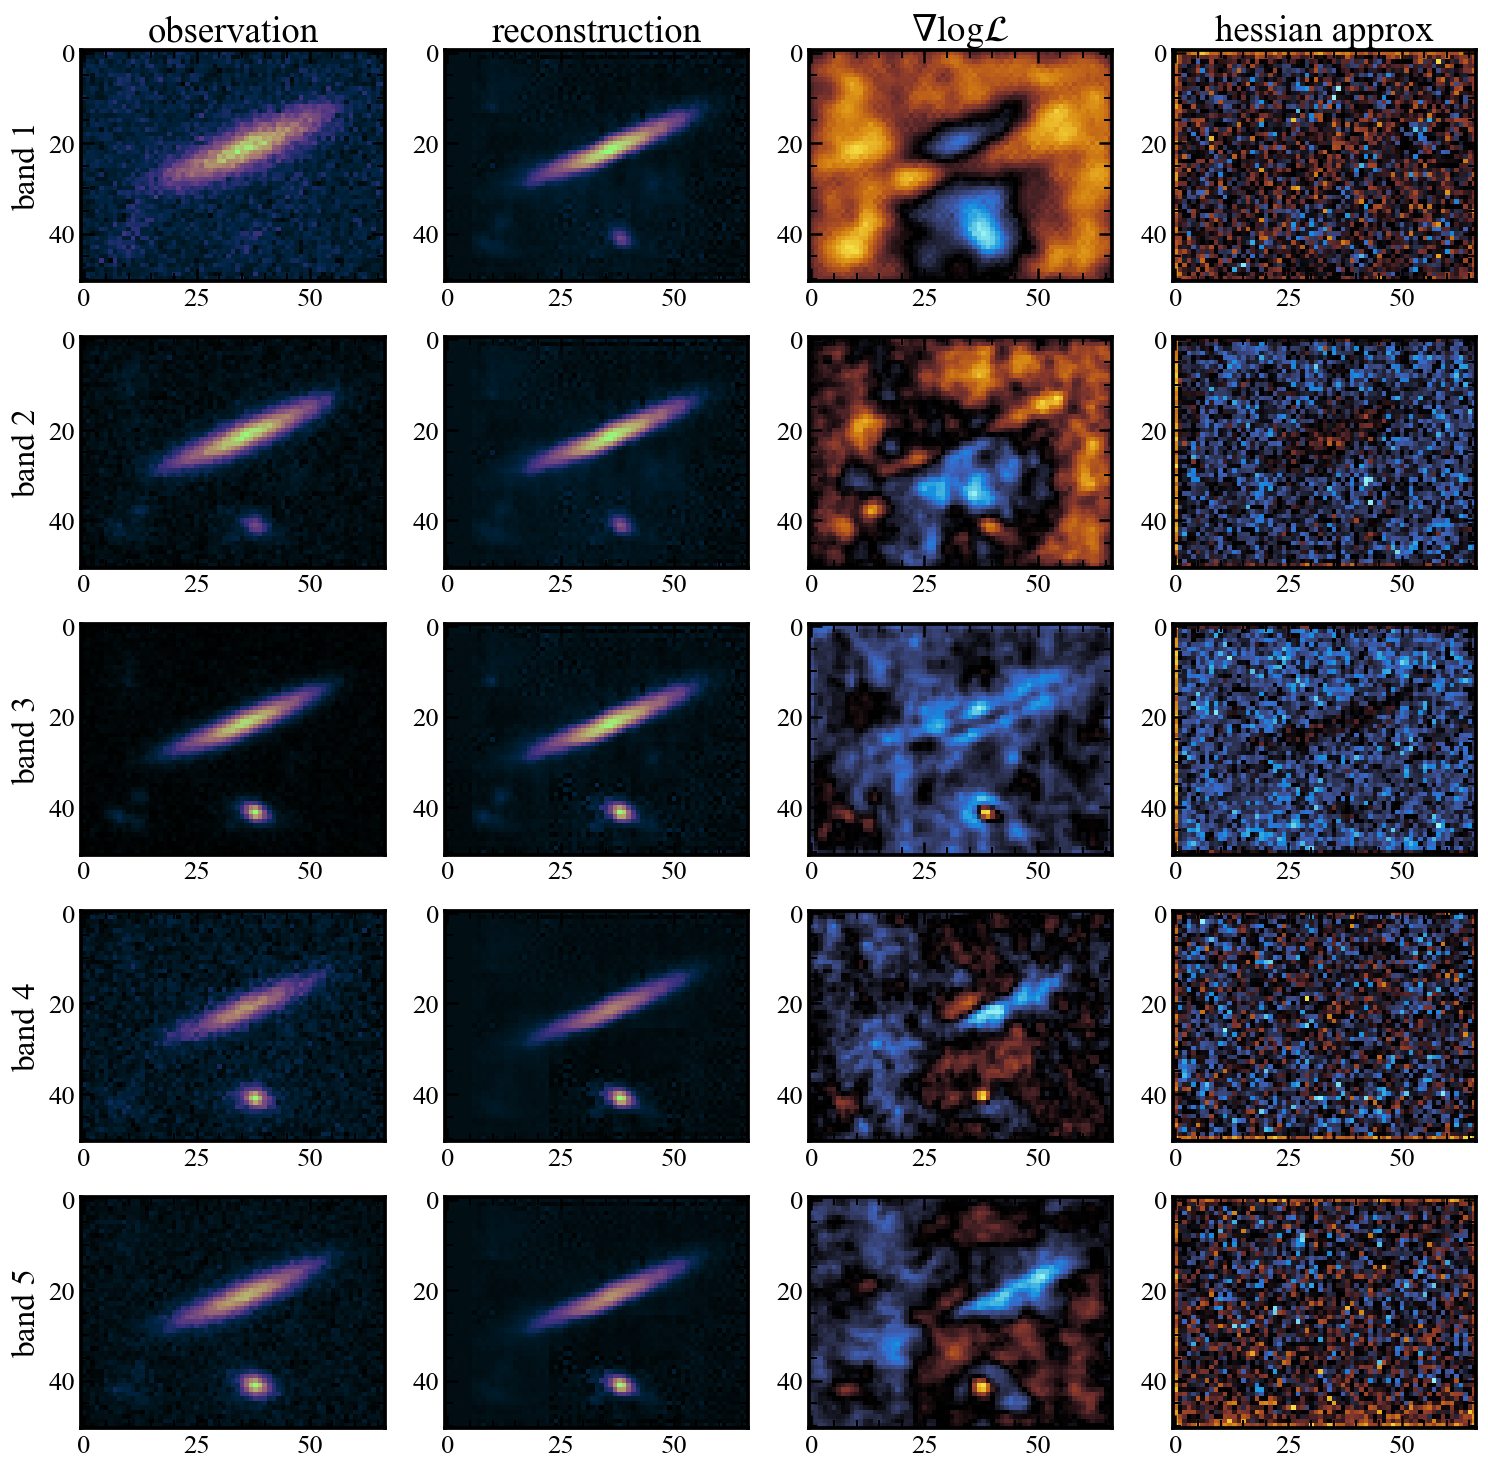

In [12]:
idx = 0
fig = plt.subplots(5, 4, figsize=(15,15),dpi=120)
plt.subplot(5,4,1)
plt.imshow(obs.data[idx], cmap = cmr.lilac)
plt.title('observation', fontsize = 22)
plt.ylabel('band 1', fontsize = 20)

plt.subplot(5,4,2)
plt.imshow(sources[idx], cmap = cmr.lilac)
plt.title('reconstruction', fontsize = 22)

plt.subplot(5,4,3)
plt.imshow(jvp_ll[idx], cmap = cmr.iceburn_r)
plt.title(r'$\nabla \mathcal{logL}$', fontsize = 22)

plt.subplot(5,4,4)
plt.imshow(hvp_ll[idx], cmap = cmr.iceburn_r)
plt.title(r'hessian approx', fontsize = 22)

idx = idx+1
plt.subplot(5,4,5)
plt.imshow(obs.data[idx], cmap = cmr.lilac)
#plt.title('observation', fontsize = 20)
plt.ylabel('band 2', fontsize = 20)

plt.subplot(5,4,6)
plt.imshow(sources[idx], cmap = cmr.lilac)
#plt.title('reconstruction', fontsize = 20)

plt.subplot(5,4,7)
plt.imshow(jvp_ll[idx], cmap = cmr.iceburn_r)
#plt.title(r'$\nabla \mathcal{logL}$', fontsize = 20)

plt.subplot(5,4,8)
plt.imshow(hvp_ll[idx], cmap = cmr.iceburn_r)
#plt.title(r'hessian approx', fontsize = 20)

idx = idx + 1
plt.subplot(5,4,9)
plt.imshow(obs.data[idx], cmap = cmr.lilac)
#plt.title('observation', fontsize = 20)
plt.ylabel('band 3', fontsize = 20)

plt.subplot(5,4,10)
plt.imshow(sources[idx], cmap = cmr.lilac)
#plt.title('reconstruction', fontsize = 20)

plt.subplot(5,4,11)
plt.imshow(jvp_ll[idx], cmap = cmr.iceburn_r)
#plt.title(r'$\nabla \mathcal{logL}$', fontsize = 20)

plt.subplot(5,4,12)
plt.imshow(hvp_ll[idx], cmap = cmr.iceburn_r)
#plt.title(r'hessian approx', fontsize = 20)

idx = idx+1
plt.subplot(5,4,13)
plt.imshow(obs.data[idx], cmap = cmr.lilac)
#plt.title('observation', fontsize = 20)
plt.ylabel('band 4', fontsize = 20)

plt.subplot(5,4,14)
plt.imshow(sources[idx], cmap = cmr.lilac)
#plt.title('reconstruction', fontsize = 20)

plt.subplot(5,4,15)
plt.imshow(jvp_ll[idx], cmap = cmr.iceburn_r)
#plt.title(r'$\nabla \mathcal{logL}$', fontsize = 20)

plt.subplot(5,4,16)
plt.imshow(hvp_ll[idx], cmap = cmr.iceburn_r)
#plt.title(r'hessian approx', fontsize = 20)

idx = idx+1
plt.subplot(5,4,17)
plt.imshow(obs.data[idx], cmap = cmr.lilac)
#plt.title('observation', fontsize = 20)
plt.ylabel('band 5', fontsize = 20)

plt.subplot(5,4,18)
plt.imshow(sources[idx], cmap = cmr.lilac)
#plt.title('reconstruction', fontsize = 20)

plt.subplot(5,4,19)
plt.imshow(jvp_ll[idx], cmap = cmr.iceburn_r)
#plt.title(r'$\nabla \mathcal{logL}$', fontsize = 20)

plt.subplot(5,4,20)
plt.imshow(hvp_ll[idx], cmap = cmr.iceburn_r)
#plt.title(r'hessian approx', fontsize = 20)

In [ ]:
scene

Scene(
  frame=Frame(
    bbox=Box(shape=(5, 51, 67), origin=(0, 0, 0)),
    psf=GaussianPSF(
      center=Parameter(value=f32[2], constraint=None, prior=None, fixed=True),
      sigma=Parameter(value=0.7, constraint=None, prior=None, fixed=True),
      bbox=Box(shape=(11, 11), origin=(-5, -5)),
      integrate=True
    ),
    wcs=None,
    channels=None
  ),
  sources=[
    Source(
      spectrum=ArraySpectrum(
        value=f32[5],
        constraint=<scarlet2.constraint.PositiveConstraint object at 0x2ab8d0100>,
        prior=None,
        fixed=False,
        bbox=Box(shape=(5,), origin=(0,))
      ),
      morphology=ArrayMorphology(
        value=f32[61,61],
        constraint=None,
        prior=<scarlet2.nn.NNPrior object at 0x31444f280>,
        fixed=False,
        bbox=Box(shape=(61, 61), origin=(-9, 6)),
        center=Parameter(value=i32[2], constraint=None, prior=None, fixed=True)
      )
    ),
    Source(
      spectrum=ArraySpectrum(
        value=f32[5],
        const

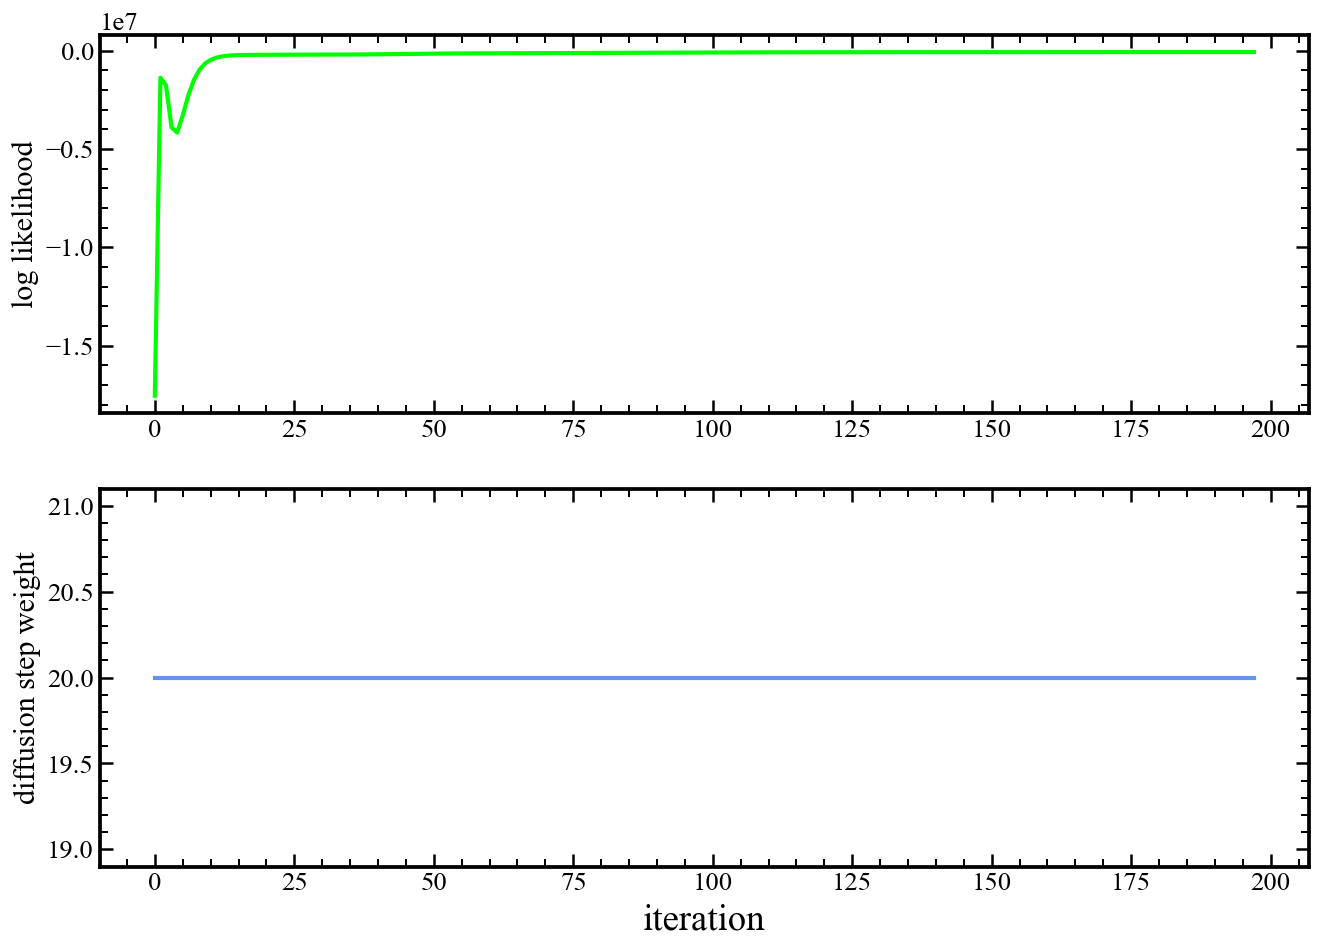

In [ ]:
fig = plt.figure(figsize=(13, 9), dpi = 120)
plt.subplot(2,1,1)
plt.plot(-1 * np.array(loss_vec[1:-1]), color='lime')
plt.ylabel("log likelihood", fontsize=18)
plt.subplot(2,1,2)
plt.plot(factor_vec[1:-1], color = 'cornflowerblue')
plt.xlabel('iteration', fontsize=22)
plt.ylabel('diffusion step weight', fontsize=18)
plt.show()

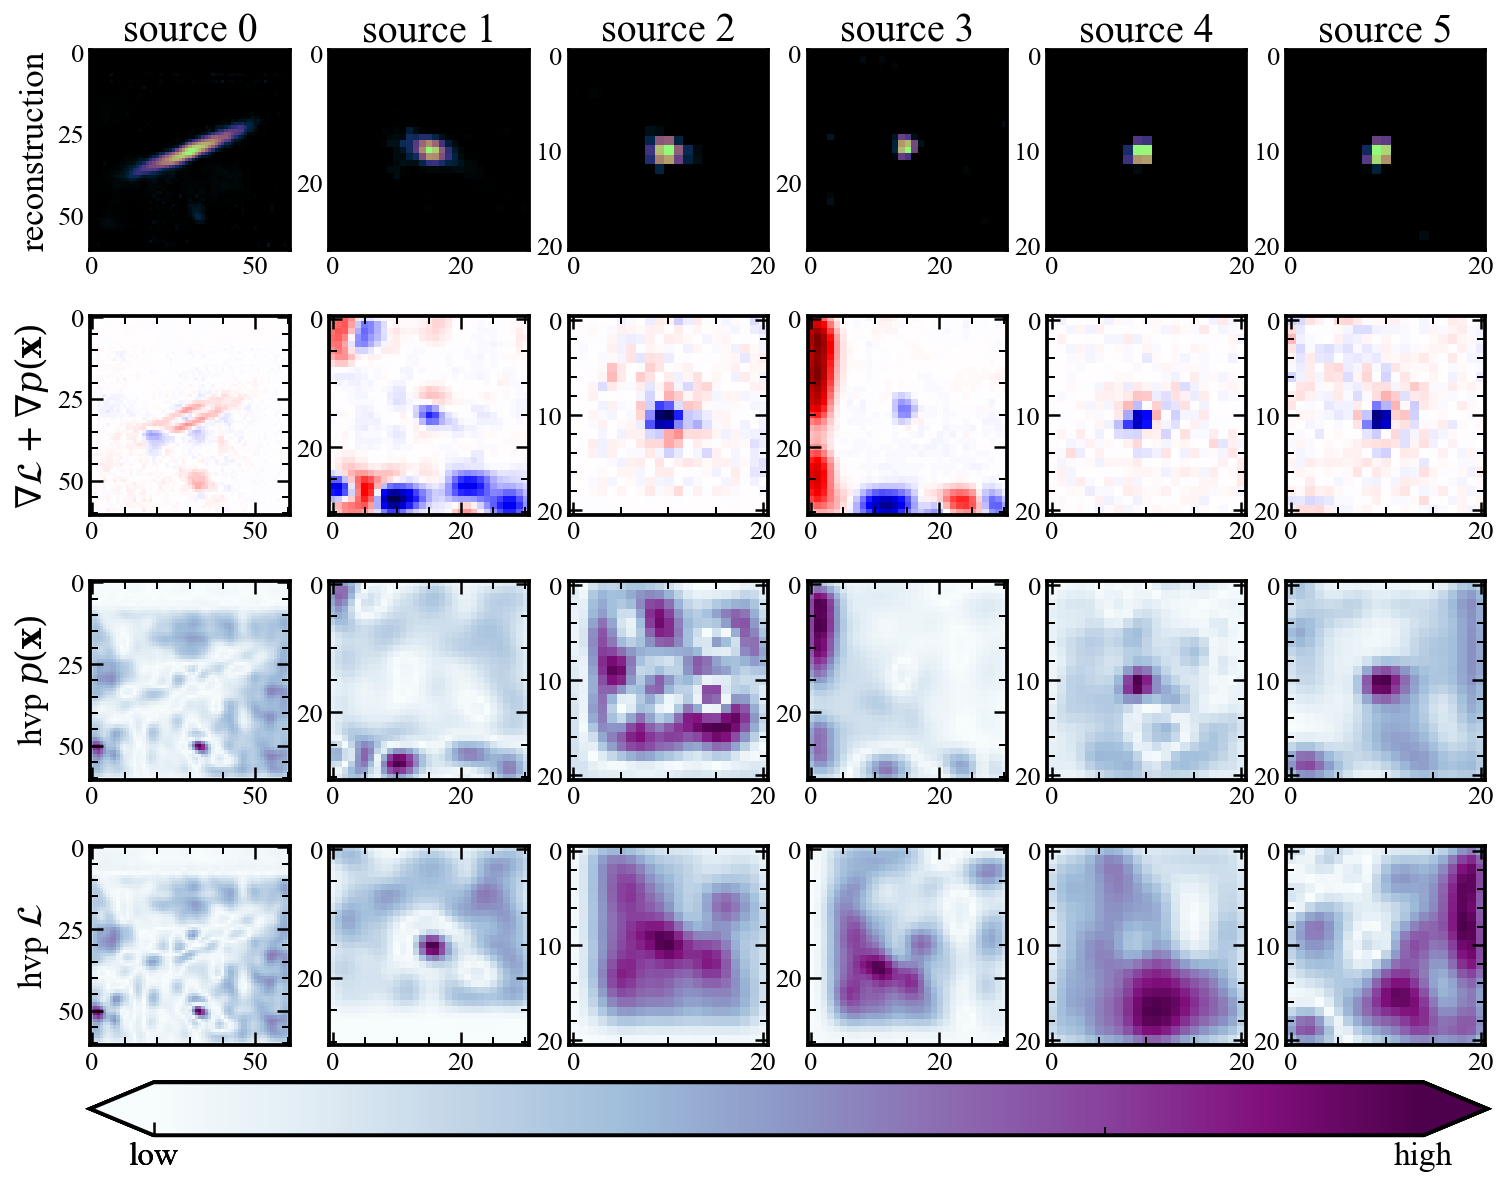

In [ ]:
# test to see if issue is with image storage type
# NOTE: nope works fine. grads correctly calculated, but not with the log_prior routine
import jax
import cmasher as cmr
int_method = 'none'
cmap = cmr.wildfire
cbar = False

from jax import jvp
def hvp(f, primals, tangents):
    return jvp(f, primals, tangents)[1]

fig = plt.figure(figsize=(15, 11), dpi = 120)
num_src = len( scene.sources )
for idx in range(num_src):
    nn_grad_fun = jax.grad(scene.sources[idx].morphology.prior.log_prob)
    sourcesL    = scene()
    #lik_grad_fun = jax.grad(-obs.log_likelihood(sourcesL[idx]))
    grad_nn    = grad_neural.sources[idx].morphology.value
    grad_nll   = grad_lik.sources[idx].morphology.value
    grad_used  = grads.sources[idx].morphology.value
    morphology = scene.sources[idx].morphology.value
    
    # make ones and identity matrix
    eye = jax.numpy.ones((grad_nn.shape[0],grad_nn.shape[0]))
    eye_2 = np.eye(grad_nn.shape[0])
    # calculate the hessian vector products
    hvp_nn    = np.abs( hvp(nn_grad_fun, (grad_nn,), (grad_nn,)) )
    hvp_ll    = np.abs( hvp(nn_grad_fun, (grad_nll,), (grad_nll,)) )
    # hvp_nn    =  np.abs( hvp(nn_grad_fun, (grad_nn,), (eye,)) )
    # hvp_ll    =  np.abs( hvp(nn_grad_fun, (grad_nll,), (eye,)) ) 
    
    # source morphology
    plt.subplot(4, num_src, idx + 1)
    plt.imshow(morphology,cmap = cmr.lilac, vmin = 0,interpolation=int_method)
    #plt.gca().invert_yaxis()
    plt.title(f"source {idx}", fontsize = 24)
    if idx==0:
        plt.ylabel("reconstruction", fontsize = 21)

        
    # nn grads
    plt.subplot(4, num_src, idx + 1 * num_src + 1)
    #plt.gca().invert_yaxis()
    tmax = np.max(np.abs(grad_nn))
    plt.imshow(grad_used,cmap = 'seismic', vmin = -tmax, vmax = tmax, interpolation=int_method)
    if idx==0:
        plt.ylabel(r"$\nabla \mathcal{L} + \nabla p(\mathbf{x})$", fontsize = 21)
    
    # residual
    plt.subplot(4, num_src, idx + 2 * num_src + 1)
    #plt.gca().invert_yaxis()
    tmax_1 = np.max(np.abs(hvp_nn))
    tmax_2 = np.max(np.abs(hvp_ll))
    tmax = np.max([tmax_1, tmax_2])
    tmin_1 = np.min(np.abs(hvp_nn))
    tmin_2 = np.min(np.abs(hvp_ll))
    tmin = np.min([tmin_1, tmin_2])
    #im = plt.imshow(hvp_nn,cmap = cmr.lilac, vmin = 0, vmax = tmax, interpolation='none')
    plt.imshow(hvp_nn,cmap = 'BuPu', interpolation='none')#,vmin = tmin, vmax = tmax)
    if idx==0:
        plt.ylabel(r"hvp $p(\mathbf{x})$", fontsize = 21)
     
    # # used grads
    plt.subplot(4,num_src, idx + 3 * num_src + 1)
    im = plt.imshow(hvp_ll,cmap = 'BuPu', interpolation=int_method)#,vmin = tmin, vmax = tmax)
    if idx==0:
        plt.ylabel(r"hvp $\mathcal{L}$", fontsize = 21)   
    cbar_ax = fig.add_axes([0.125, 0.05, 0.776, 0.040])
    cbar = fig.colorbar(im, cax=cbar_ax,ticks=[tmin, tmax],
                orientation="horizontal",
                extend='both')
    cbar.set_ticklabels(['low', 'high'], fontsize=20) 
# save figure
saveName = f"figures/grads_{iters}.png"
#plt.savefig(saveName, bbox_inches='tight', dpi=300)


In [ ]:
import cmasher as cmr
# TODO: Make proper normalising and stretching routine like the Lupton one
from astropy.visualization.stretch import SinhStretch, LinearStretch
from astropy.visualization import ImageNormalize
stretch = LinearStretch(slope=0.5, intercept=0.5) + SinhStretch() + \
    LinearStretch(slope=1, intercept=-1)
norm = ImageNormalize(stretch=stretch, vmin=0, vmax=2)
int_method='none'
cmap = cmr.lilac

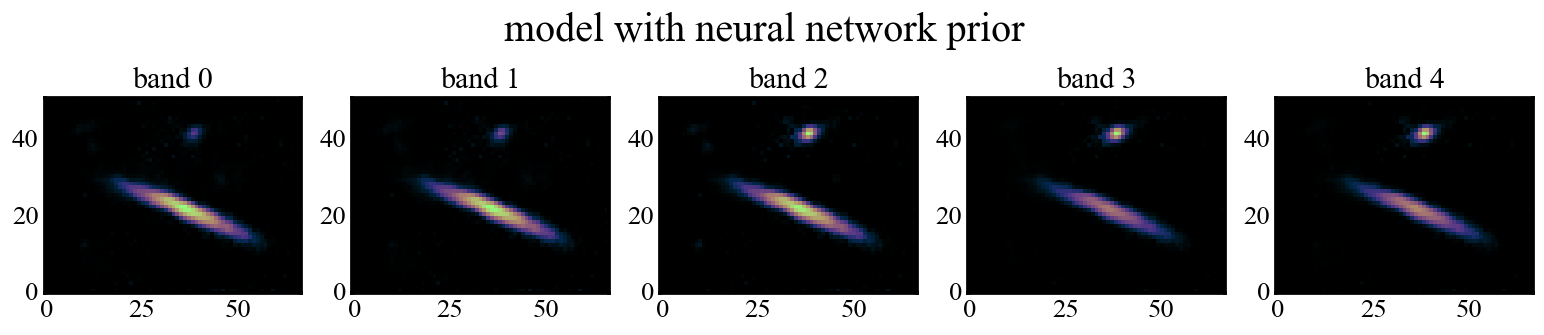

In [ ]:
# create some plots to see how the sources look
sources = scene()
fig, axes = plt.subplots(1, sources.shape[0], figsize=(16,6),dpi=120)
for i, ax in enumerate(axes):
    ax.imshow(sources[i], cmap = cmap, vmin = 0,  interpolation=int_method)
    ax.set_title(f"band {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('model with neural network prior', fontsize=24,y=0.75)
plt.show()

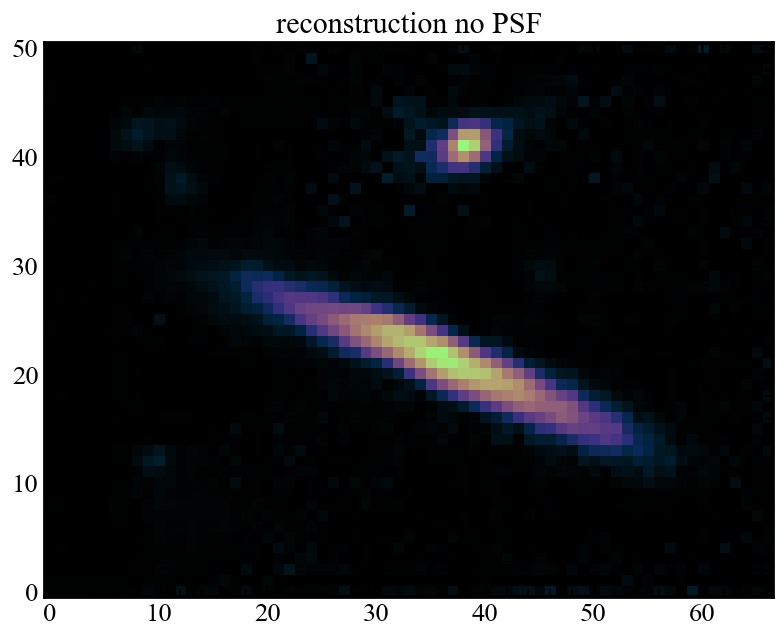

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16,6),dpi=120)
y = sources[2]
ax.imshow(y, cmap = cmap, vmin = -0.1,  interpolation=int_method)
#ax.imshow(y, cmap = cmap, norm=norm,  interpolation=int_method)
ax.set_title(f"reconstruction no PSF", fontsize = 18)
ax.invert_yaxis()
#plt.suptitle('model no prior', fontsize=24,y=0.72)
plt.show()

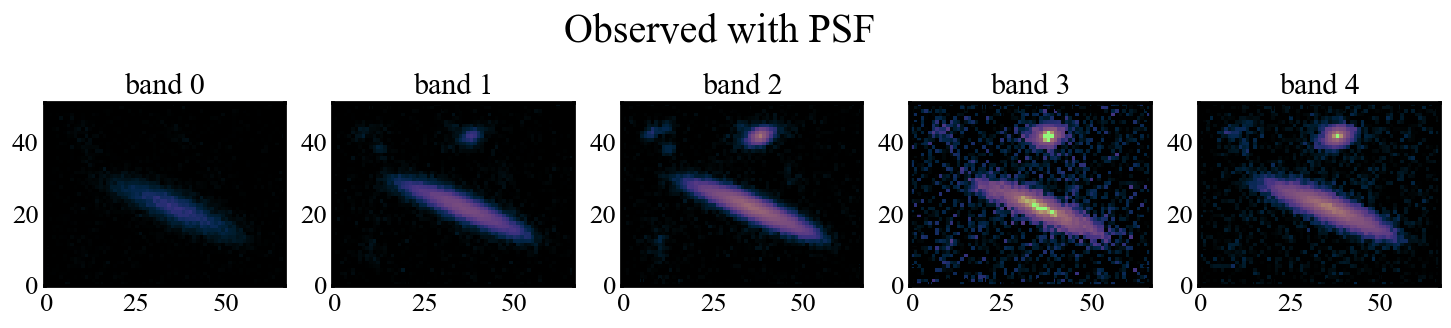

In [ ]:
fig, axes = plt.subplots(1, sources.shape[0], figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    ax.imshow(obs.data[i], cmap = cmap,norm=norm, interpolation=int_method)
    #ax.imshow(obs.data[i], cmap = cmap,vmin=0, interpolation=int_method)
    ax.set_title(f"band {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('Observed with PSF', fontsize=24,y=0.75)
plt.show()

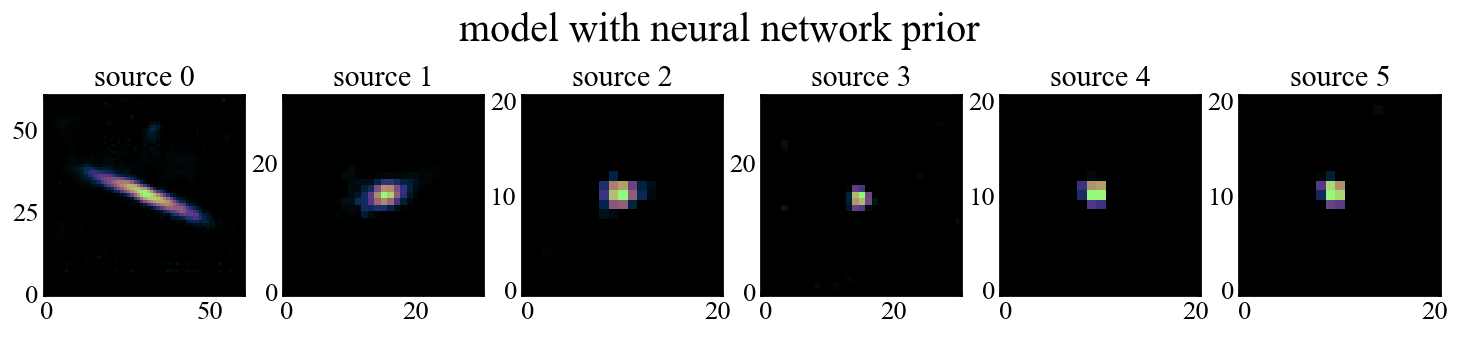

<Figure size 2000x1400 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(1, len( scene.sources ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    y = scene.sources[i].morphology.value
    ax.imshow(y, cmap = cmap, vmin = 0,interpolation=int_method)
    ax.set_title(f"source {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('model with neural network prior', fontsize=24,y=0.75)
#plt.suptitle('model no prior', fontsize=24,y=0.75)
plt.show()
plt.clf()

In [ ]:
# observation model plus rendered
renders = obs.render(scene())

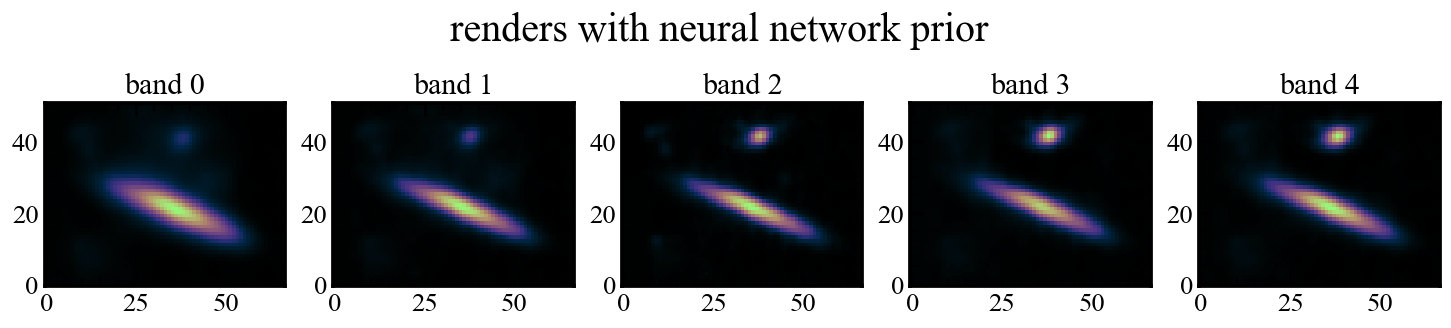

<Figure size 2000x1400 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(1, len( renders ), figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    y = renders[i]
    #ax.imshow(y, cmap = cmap,vmin=0,interpolation=int_method)
    #ax.imshow(y, cmap = cmap,norm=norm,interpolation=int_method)
    ax.imshow(y, cmap = cmap,interpolation=int_method)
    ax.set_title(f"band {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('renders with neural network prior', fontsize=24,y=0.75)
#plt.suptitle('model no prior', fontsize=24,y=0.75)
plt.show()
plt.clf()

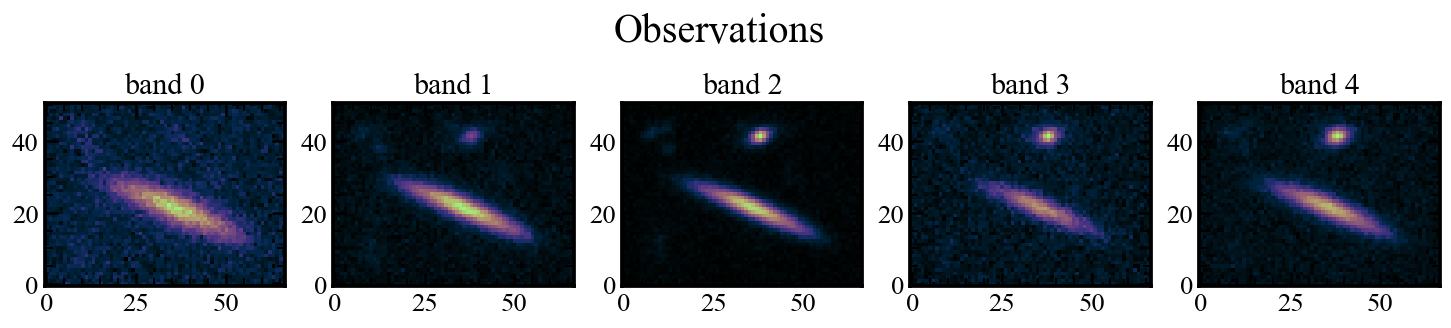

In [ ]:
fig, axes = plt.subplots(1, sources.shape[0], figsize=(15,6),dpi=120)
for i, ax in enumerate(axes):
    #ax.imshow(obs.data[i], cmap = cmap,norm=norm, interpolation=int_method)
    ax.imshow(obs.data[i], cmap = cmap,interpolation=int_method)
    ax.set_title(f"band {i}", fontsize = 18)
    ax.invert_yaxis()
plt.suptitle('Observations', fontsize=24,y=0.75)
plt.show()

In [ ]:
ll_grad_fun  = jax.grad(likelihood(scene, obs))
nn_grad_fun = jax.grad(scene.sources[idx].morphology.prior.log_prob)

sources = scene()

def solo_like(sources):
    return -obs.log_likelihood(sources)

ll_grad_fun = jax.grad(solo_like)
jvp_ll = ll_grad_fun(sources)
hvp_ll    = hvp_rad(ll_grad_fun, (jvp_ll,), jvp_ll.shape)

Text(0.5, 1.0, 'hessian approx')

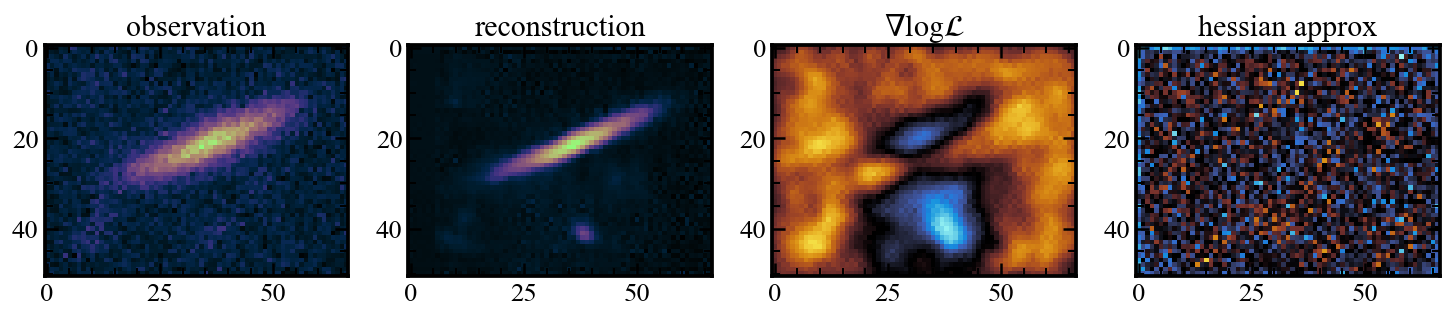

In [ ]:
fig = plt.subplots(1, 4, figsize=(15,6),dpi=120)
plt.subplot(1,4,1)
plt.imshow(obs.data[0], cmap = cmr.lilac)
plt.title('observation', fontsize = 18)

plt.subplot(1,4,2)
plt.imshow(sources[0], cmap = cmr.lilac)
plt.title('reconstruction', fontsize = 18)

plt.subplot(1,4,3)
plt.imshow(jvp_ll[0], cmap = cmr.iceburn_r)
plt.title(r'$\nabla \mathcal{logL}$', fontsize = 18)

plt.subplot(1,4,4)
plt.imshow(hvp_ll[0], cmap = cmr.iceburn)
plt.title(r'hessian approx', fontsize = 18)